In [9]:
#Fase 1. Cargar y explorar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

df = pd.read_csv('/content/online_retail_II.csv')

print("---Primeras 5 filas---")
print(df.head())

print("\n--- Información del DataFrame---")
df.info()

print(f"\n--- Conteo de datos nulos por columna----")
print(df.isnull().sum())

---Primeras 5 filas---
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  

--- Información del DataFrame---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  


In [10]:
#Fase 2. Limpieza y feature engineering

df_clean = df.copy()

print(f"Filas originales: {len(df_clean)}")
#1-Limpio nulos
df_clean.dropna(subset=["Customer ID"])

print(f"Filas después de sacar los nulos en 'Customer ID': {len(df_clean)}")
#2-Limpieza de transacciones. El dataset incluye devoluciones (cuya cantidad es <0) y nosotros solo queremos compras reales y con valor (cantidad y precio >0)
df_clean = df_clean[df_clean['Quantity'] > 0]
df_clean = df_clean[df_clean['Price'] > 0]

print(f"Filas después de quitar devoluciones/precios cero: {len(df_clean)}")

#3- Conversión de Tipos. No podemos calcular recencia (R) si la fecha es texto.
df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"])

#4- Creación de "TotalPrice". Lo que será nuestra base de nuestro "monetary" (M)
df_clean["TotalPrice"] = df_clean["Quantity"] * df_clean["Price"]

print("\n--- Datos limpios para RFM---")
print(df_clean[["Customer ID", "InvoiceDate", "TotalPrice"]].head())

print("\n--- Nueva info del df limpio")
df_clean.info()

Filas originales: 1067371
Filas después de sacar los nulos en 'Customer ID': 1067371
Filas después de quitar devoluciones/precios cero: 1041671

--- Datos limpios para RFM---
   Customer ID         InvoiceDate  TotalPrice
0      13085.0 2009-12-01 07:45:00        83.4
1      13085.0 2009-12-01 07:45:00        81.0
2      13085.0 2009-12-01 07:45:00        81.0
3      13085.0 2009-12-01 07:45:00       100.8
4      13085.0 2009-12-01 07:45:00        30.0

--- Nueva info del df limpio
<class 'pandas.core.frame.DataFrame'>
Index: 1041671 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1041671 non-null  object        
 1   StockCode    1041671 non-null  object        
 2   Description  1041671 non-null  object        
 3   Quantity     1041671 non-null  int64         
 4   InvoiceDate  1041671 non-null  datetime64[ns]
 5   Price        1041671 non-null  float64      

In [11]:
#Fase 3. Cálculo de R, F y M (Agrupar por cliente, calcular Recencia, Frecuencia y Monetario).

#1- Definimos la fecha de "corte".
fecha_corte = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"La fecha de corte, nuestro('hoy'), para el análisis es: {fecha_corte}")

#2- Agrupo y calculo R, F, M.
rfm_df = df_clean.groupby('Customer ID').agg(
    #Recency (R): Cuán recientemente compró? Resto la fecha de corte a la fecha de compra más reciente y se lo pido en días.
    recency=('InvoiceDate', lambda x: (fecha_corte - x.max()). days),

    #Frequency (F): Cuántas veces compró? Cuento el número de facturas (Invoices) únicas de ese cliente.
    frequency=('Invoice', 'nunique'),

    #Monetary (M): Cuánta plata gastó? Sumo el TotalPrice de todas sus transacciones.
    monetary=('TotalPrice', 'sum')
).reset_index()
#Convierto la columna Customer ID a número entero
rfm_df['Customer ID'] = rfm_df['Customer ID'].astype(int)
#3- vistazo final
print("\n Tabla RFM generada")
print(rfm_df.head())

print("\n Estadísticas descriptivas de RFM")
print(rfm_df[['recency', 'frequency', 'monetary']].describe())

La fecha de corte, nuestro('hoy'), para el análisis es: 2011-12-10 12:50:00

 Tabla RFM generada
   Customer ID  recency  frequency  monetary
0        12346      326         12  77556.46
1        12347        2          8   5633.32
2        12348       75          5   2019.40
3        12349       19          4   4428.69
4        12350      310          1    334.40

 Estadísticas descriptivas de RFM
           recency    frequency       monetary
count  5878.000000  5878.000000    5878.000000
mean    201.331916     6.289384    3018.616737
std     209.338707    13.009406   14737.731040
min       1.000000     1.000000       2.950000
25%      26.000000     1.000000     348.762500
50%      96.000000     3.000000     898.915000
75%     380.000000     7.000000    2307.090000
max     739.000000   398.000000  608821.650000


In [28]:
#Fase 4.
#1- Creo puntuaciones (Scores) por cuartiles. Defino etiquetas para los 4 grupos. Una nota clave: para recencia las etiquetas están invertidas.
#Menos días (mejor) = 4 puntos. Más días (peor) = 1 punto.
r_labels = [4, 3, 2, 1]
f_labels = [1, 2, 3, 4]
m_labels = [1, 2, 3, 4]

#Por qué pd.qcut? Es la función de 'corte por cuantiles' (quartiles en este caso).
#Pandas automáticamente encontrará los valores para cortar a los clientes en 4 grupos de (casi) el mismo tamaño
#Por qué duplicates='drop'?
#CRÍTICO! En la Fase 3 vi que Frecuencia tenía una mediana de 1. Esto significa que más del 50% de los clientes tienen F=1.
#'qcut' fallaría al tratar de cortar esto en 4 grupos.
#'duplicates=drop' le dice a Pandas: "Si no podés hacer 4 grupos, hacé los que puedas (ej. 2 o 3) y poné a todos los duplicados juntos"
#Este código no me funcionó porque programa falla porque no sabe cómo asignar 4 etiquetas a 2 grupos.
#rfm_df['r_Score'] = pd.qcut(rfm_df['recency'], q=4, labels=r_labels, duplicates='drop')
#rfm_df['f_Score'] = pd.qcut(rfm_df['frequency'], q=4, labels=f_labels, duplicates='drop')
#rfm_df['m_Score'] = pd.qcut(rfm_df['monetary'], q=4, labels=m_labels, duplicates='drop')
#pd.qcut() simple fallaba porque 'Frequency' y 'Monetary' tienen demasiados valores duplicados (ej. >50% de clientes con F=1).
#Esto hacía imposible cortarlos en 4 grupos (q=4).

# SOLUCIÓN: Usar .rank(method='first') primero.
#.rank() "rompe los empates" asignando un "puesto" único a cada cliente.
#Luego, qcut SÍ puede cortar esos "puestos" únicos en 4 cuartiles perfectos.
rfm_df['r_score'] = pd.qcut(rfm_df['recency'].rank(method='first'), q=4, labels=r_labels)
rfm_df['f_score'] = pd.qcut(rfm_df['frequency'].rank(method='first'), q=4, labels=f_labels)
rfm_df['m_score'] = pd.qcut(rfm_df['monetary'].rank(method='first'), q=4, labels=m_labels)
print("\n Tabla RFM con scores (1-4)")
print(rfm_df.head())

#2. Combinar Scores en un "Código RFM"
#Combino los 3 scores en un "código" de texto (ej. '444' o '222') lo que me permite crear segmentos de forma más fácil
rfm_df['rfm_score'] = rfm_df['r_score'].astype(str) + rfm_df['f_score'].astype(str) + rfm_df['m_score'].astype(str)

print("\n Tabla RFM con código combinado")
print(rfm_df[['Customer ID', 'rfm_score']].head())

#3. mapeo los códigos a segmentos
#Acá traduzco los códigos a estrategias de negocio. Uso expresiones regulares (regex) para buscar patrones
#r'^[3-4][3-4][3-4]$' significa: R es 3 o 4, Y F es 3 o 4, Y M es 3 o 4.
segment_map = {
    r'^[3-4][3-4][3-4]$': '1. Clientes VIP',        # R, F, M altos
    r'^[1-2][3-4][3-4]$': '2. Clientes en Riesgo',  # R bajo, pero F y M altos (¡eran buenos!)
    r'^[3-4]1[1-2]$':     '3. Clientes Nuevos',     # R alto, F y M bajos (1 sola compra reciente)
    r'^[1-2]11$':         '4. Clientes Perdidos',   # R, F, M bajos
    r'^[2-3][2-3][2-3]$': '5. Clientes Promedio'  # Todos en el medio'
}

rfm_df['segmento'] = rfm_df['rfm_score'].replace(segment_map, regex=True)
#Esto lo hago porque si un código no coincidió con ninguna regla(ej. '421'), le asigno a "6. Otros"
rfm_df['segmento'] = rfm_df['segmento'].apply(lambda x: x if x.startswith(('1.', '2.', '3.', '4.', '5.')) else '6. Otros')

print("\n segmentación completa")
print(rfm_df[['Customer ID', 'rfm_score', 'segmento']].head())

print("\n conteo de clientes por segmento")
print(rfm_df['segmento'].value_counts())


 Tabla RFM con scores (1-4)
   Customer ID  recency  frequency  monetary r_score r_Score R_Score F_Score  \
0        12346      326         12  77556.46       2       2       2       4   
1        12347        2          8   5633.32       4       4       4       4   
2        12348       75          5   2019.40       3       3       3       3   
3        12349       19          4   4428.69       4       4       4       3   
4        12350      310          1    334.40       2       2       2       1   

  M_Score f_Score m_Score f_score m_score rfm_score               segmento  
0       4       4       4       4       4       244  2. Clientes en Riesgo  
1       4       4       4       4       4       444        1. Clientes VIP  
2       3       3       3       3       3       333        1. Clientes VIP  
3       4       3       4       3       4       434        1. Clientes VIP  
4       1       1       1       1       1       211   4. Clientes Perdidos  

 Tabla RFM con código combi

/tmp/ipython-input-2889385495.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0, 0], data=segment_summary, y='segmento', x='Count', palette='viridis')
/tmp/ipython-input-2889385495.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0, 1], data=segment_summary, y='segmento', x='avg_monetary', palette='plasma')
/tmp/ipython-input-2889385495.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1, 0], data=segment_summary, y='segmento', x='avg_frequency', palette='coolwarm')
/tmp/ipython-input-2889385495.py:46: Fut

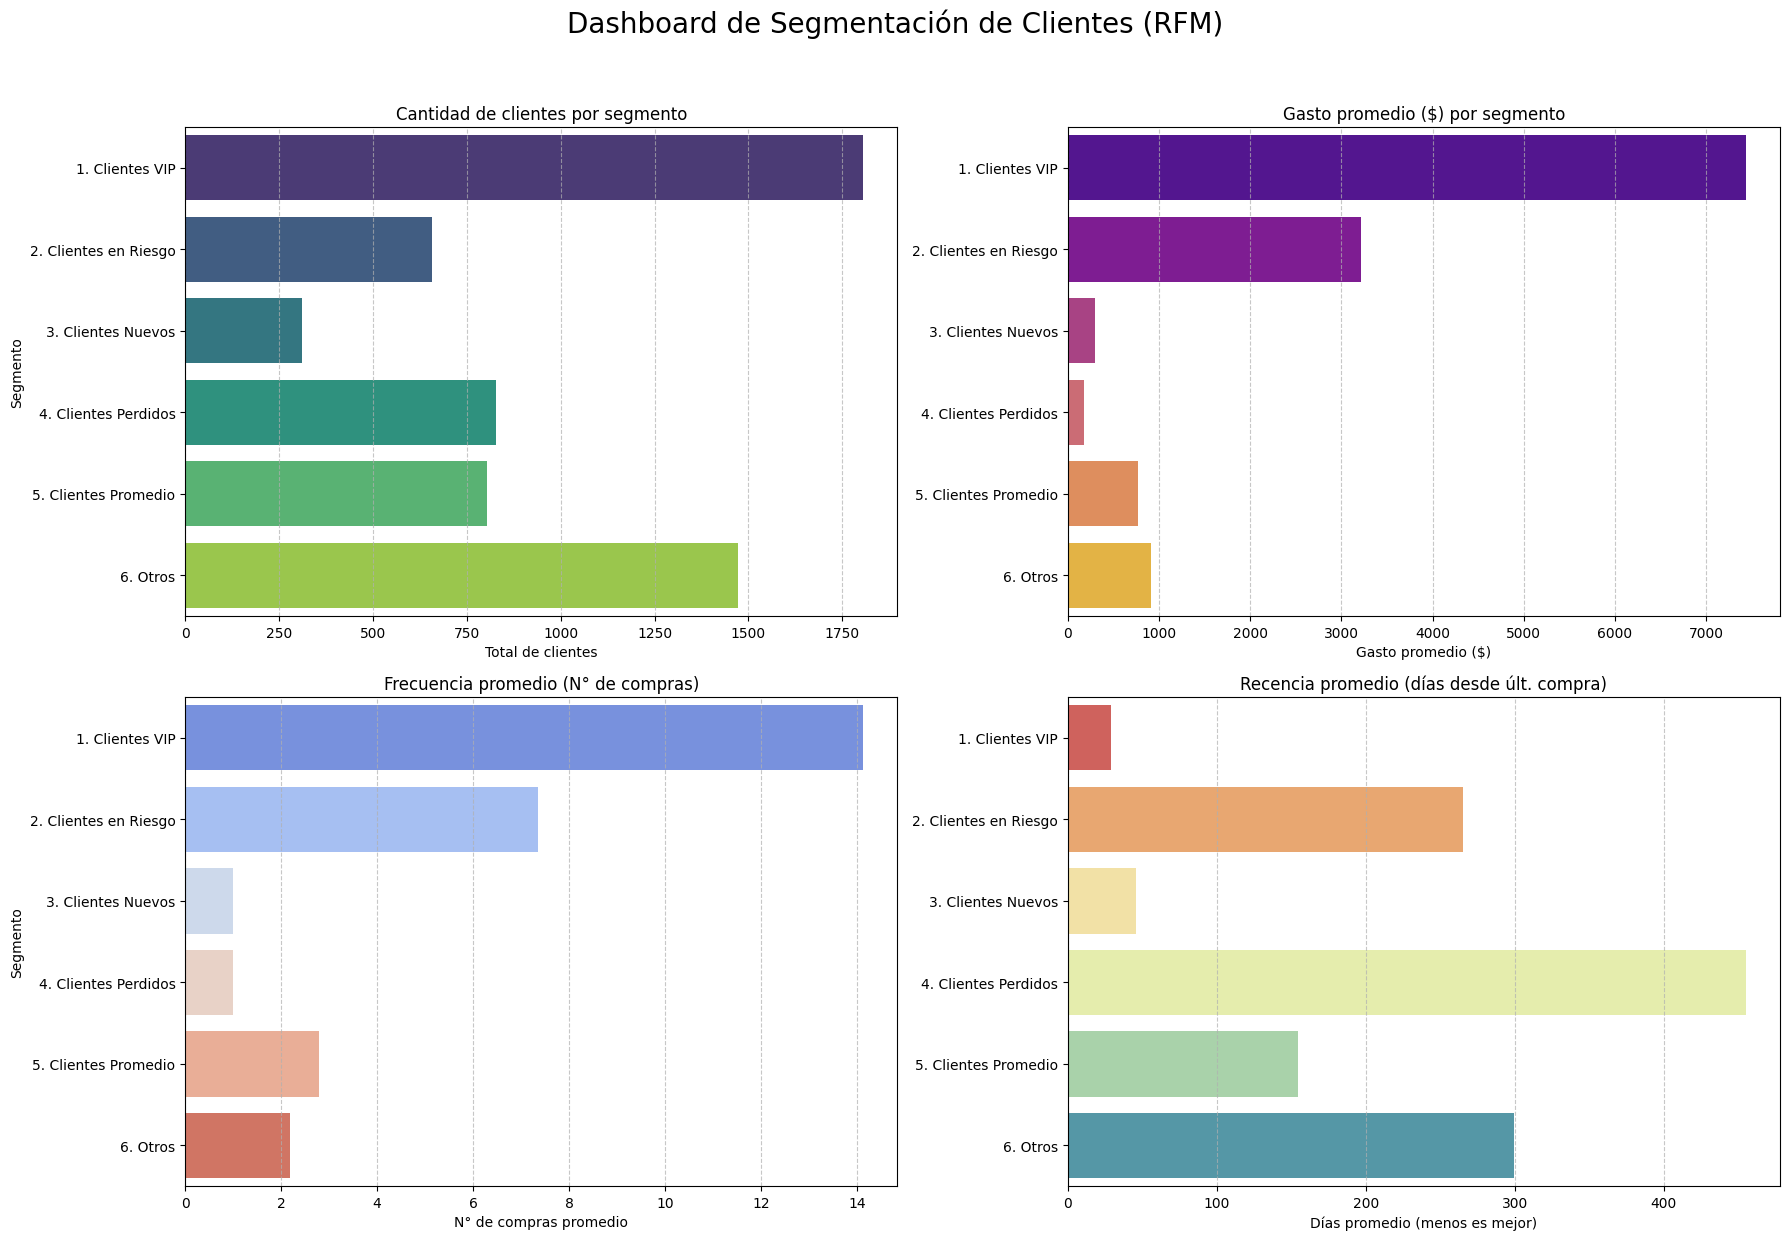

In [41]:
#Fase 5.
#Tabla resumen
segment_summary = rfm_df.groupby('segmento').agg(
    avg_recency=('recency', 'mean'),
    avg_frequency=('frequency', 'mean'),
    avg_monetary=('monetary', 'mean'),
    Count=('Customer ID', 'count')
).reset_index().sort_values(by='segmento')


# --- Creo el Dashboard 2x2 ---

# 1. Creo la "figura" (el lienzo) y los "ejes" (los 4 espacios para gráficos)
# (2, 2) significa 2 filas, 2 columnas.
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 2. Título principal del Dashboard
fig.suptitle('Dashboard de Segmentación de Clientes (RFM)', fontsize=20, y=1.03)


# --- Gráfico 1: Cantidad de clientes (Top-Izquierda) ---
sns.barplot(ax=axes[0, 0], data=segment_summary, y='segmento', x='Count', palette='viridis')
axes[0, 0].set_title('Cantidad de clientes por segmento')
axes[0, 0].set_xlabel('Total de clientes')
axes[0, 0].set_ylabel('Segmento')
axes[0, 0].grid(axis='x', linestyle='--', alpha=0.7)


# --- Gráfico 2: Gasto promedio (Top-Derecha) ---
sns.barplot(ax=axes[0, 1], data=segment_summary, y='segmento', x='avg_monetary', palette='plasma')
axes[0, 1].set_title('Gasto promedio ($) por segmento')
axes[0, 1].set_xlabel('Gasto promedio ($)')
axes[0, 1].set_ylabel(None) # Saco la etiqueta Y (redundante)
axes[0, 1].grid(axis='x', linestyle='--', alpha=0.7)


# --- Gráfico 3: Frecuencia promedio (Bottom-Izquierda) ---
sns.barplot(ax=axes[1, 0], data=segment_summary, y='segmento', x='avg_frequency', palette='coolwarm')
axes[1, 0].set_title('Frecuencia promedio (N° de compras)')
axes[1, 0].set_xlabel('N° de compras promedio')
axes[1, 0].set_ylabel('Segmento')
axes[1, 0].grid(axis='x', linestyle='--', alpha=0.7)


# --- Gráfico 4: Recencia Promedio (Bottom-Derecha) ---
sns.barplot(ax=axes[1, 1], data=segment_summary, y='segmento', x='avg_recency', palette='Spectral')
axes[1, 1].set_title('Recencia promedio (días desde últ. compra)')
axes[1, 1].set_xlabel('Días promedio (menos es mejor)')
axes[1, 1].set_ylabel(None) # Saco la etiqueta Y (redundante)
axes[1, 1].grid(axis='x', linestyle='--', alpha=0.7)


# --- Ajuste final y mostrar ---
plt.tight_layout() # Ajusta los gráficos para que no se superpongan
plt.show()